In [73]:
import env
import pandas as pd
import numpy as np
import utilities as utils
import re
import nltk

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_articles
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_graphviz
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [ ]:
# Run on first time or to renew csv files
#articles_df = wrangle_articles()

#articles_df.to_csv("articles.csv")

In [31]:
articles_df = pd.read_csv("articles.csv", index_col=0)

In [32]:
articles_df.head(5)

,title,text,subject,date,is_fake,clean_title,clean_text,title_polarity,title_subjectivity,text_polarity,text_subjectivity
37302,FLASHBACK: KING OBAMA COMMUTES SENTENCES OF 22...,Just making room for Hillary President Obama t...,politics,2015-03-31,True,flashback king obama commute sentence 22 drug ...,making room hillary president obama today anno...,0.000000,0.000000,-0.201587,0.493452
37303,APPLE’S CEO SAYS RELIGIOUS FREEDOM LAWS ARE ‘D...,The gay mafia has a new corporate Don. This i...,politics,2015-03-31,True,apple ceo say religious freedom law dangerous ...,gay mafia new corporate article need read shee...,0.058333,0.579167,-0.040032,0.582057
37304,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",politics,2015-03-31,True,watch dirty harry reid lie romneys tax didnt win,case missed sen harry reid rnv announced last ...,0.100000,0.600000,0.150000,0.511111
37305,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,politics,2015-03-31,True,oh guess funded shrine ted kennedy,nothing like political cronyism make stomach c...,0.000000,0.000000,0.122865,0.441116
37306,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,2015-03-31,True,benghazi panel call hillary testify oath white...,anyone really think hillary clinton come clean...,0.000000,0.000000,0.110586,0.433784


In [33]:
articles_df.shape

(38651, 11)

In [34]:
utils.nan_null_empty_check(articles_df)

NaN values
Empty DataFrame
Columns: [rows, columns]
Index: []
--------------------------------
Empty values
Empty DataFrame
Columns: [rows, columns]
Index: []
--------------------------------


{'nan_positions': (array([], dtype=int64), array([], dtype=int64)),
 'empty_positions': (array([], dtype=int64), array([], dtype=int64))}

# Exploration

In [35]:
def show_counts_and_ratios(df, column):
    """
    This function takes in a df and column name.
    Will produce a valuecounts for each label and the percetage of the data it represents
    """
    fof = pd.concat([df.is_fake.value_counts(),
                        df.is_fake.value_counts(normalize=True)], axis=1)
    fof.columns = ['n', 'percent']
    
    return fof

In [37]:
show_counts_and_ratios(articles_df, 'is_fake')

,n,percent
False,21196,0.548395
True,17455,0.451605


In [41]:
fake_words = (' '.join(articles_df[articles_df.is_fake == True].clean_text))
real_words = (' '.join(articles_df[articles_df.is_fake == False].clean_text))
all_words = (' '.join(articles_df.clean_text))

In [42]:
fake_words = re.sub(r"[^\w\s]", "", fake_words).split()
real_words = re.sub(r"[^\w\s]", "", real_words).split()
all_words = re.sub(r"[^\w\s]", "", all_words).split()

## Top Ten Words for fake-real-all

In [44]:
fake_freq = pd.Series(fake_words).value_counts()

fake_freq.head(10)

trump        63612
said         22915
people       20742
president    19576
one          18216
would        18163
state        15895
u            14809
donald       14786
like         14452
dtype: int64

In [45]:
real_freq = pd.Series(real_words).value_counts()

real_freq.head(10)

said          97808
trump         53734
u             40656
state         35942
would         31155
president     26689
republican    21964
government    19169
year          18540
house         16775
dtype: int64

In [46]:
all_freq = pd.Series(all_words).value_counts()

all_freq.head(10)

said          120723
trump         117346
u              55465
state          51837
would          49318
president      46265
republican     36001
people         35863
one            31120
year           29363
dtype: int64

# Takeaways
* The top words for fake news articles are: trump, said, people, president, one.
* The top words for real news articles are: said, trump, u, state, would. 
* The top words for all news articles are: said, trump, u, state, would

## Word count proportions

In [47]:
word_counts = (pd.concat([all_freq, fake_freq, real_freq], axis=1, sort=True)
                .set_axis(['all', 'fake', 'real'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [48]:
word_counts.sort_values(by='all', ascending=False).head(50)

,all,fake,real
said,120723,22915,97808
trump,117346,63612,53734
u,55465,14809,40656
state,51837,15895,35942
would,49318,18163,31155
president,46265,19576,26689
republican,36001,14037,21964
people,35863,20742,15121
one,31120,18216,12904
year,29363,10823,18540


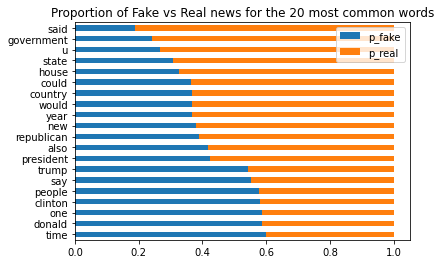

In [51]:
(word_counts
 .assign(p_fake=word_counts.fake / word_counts['all'],
         p_real=word_counts.real / word_counts['all'])
 .sort_values(by='all')
 [['p_fake', 'p_real']]
 .tail(20)
 .sort_values('p_real')
 .plot.barh(stacked=True))

plt.title('Proportion of Fake vs Real news for the 20 most common words')
plt.show()

# Takeaways
* We found that time, one, donald, people, and clinton were the words that appeared in greater proportion in fake news stories.

In [61]:
word_counts_all = (word_counts
 [(word_counts.fake > 10) & (word_counts['all'] > 10)]
 .assign(ratio=lambda df: df.fake / (df['all'] + .01))
 .sort_values(by='all', ascending = False)
 .pipe(lambda df: pd.concat([df.head(), df.head(20)])))

In [62]:
word_counts_all

,all,fake,real,ratio
said,120723,22915,97808,0.189815
trump,117346,63612,53734,0.542089
u,55465,14809,40656,0.266997
state,51837,15895,35942,0.306634
would,49318,18163,31155,0.368283
said,120723,22915,97808,0.189815
trump,117346,63612,53734,0.542089
u,55465,14809,40656,0.266997
state,51837,15895,35942,0.306634
would,49318,18163,31155,0.368283


* 50 percent of all had trump as a keyword, 54 percent of these instances are fake.
* The higest amkount of instances is associated with the word said at 118359 instances.
* The word said only occured in 19% of fake articles, while 81% where associated with real news articles.
* The second highest ammount of intances is associated with the word/name trump at 115797 intances and making up over 53% being in fake news realted articles. 

In [59]:
word_counts_fake = (word_counts
 [(word_counts.fake > 10) & (word_counts.real > 10)]
 .assign(ratio=lambda df: df.fake / (df.real + .01))
 .sort_values(by='ratio', ascending = False)
 .pipe(lambda df: pd.concat([df.head(), df.head(20)])))

In [60]:
word_counts_fake

,all,fake,real,ratio
cop,956,940,16,58.713304
hannity,955,939,16,58.650843
gop,3787,3696,91,40.610922
damn,440,428,12,35.636969
rant,472,459,13,35.280553
cop,956,940,16,58.713304
hannity,955,939,16,58.650843
gop,3787,3696,91,40.610922
damn,440,428,12,35.636969
rant,472,459,13,35.280553


* Fake news articles tend to have words with negative connotations such as bigoted, disgusting, pathetic, insane, and idiot. 

In [63]:
word_counts_real = (word_counts
 [(word_counts.fake > 10) & (word_counts.real > 10)]
 .assign(ratio=lambda df: df.real / (df.fake + .01))
 .sort_values(by='ratio', ascending = False)
 .pipe(lambda df: df.head(20)))

In [64]:
word_counts_real

,all,fake,real,ratio
thats,1166,17,1149,67.548501
im,1229,18,1211,67.240422
lebanese,671,11,660,59.945504
dont,2044,38,2006,52.775585
parliamentary,804,15,789,52.564957
km,704,14,690,49.250535
ankara,892,18,874,48.528595
beijing,2128,44,2084,47.352874
beirut,524,11,513,46.594005
hong,562,12,550,45.795171


* Real news articles use words that are more centered around world events and places.
* Ankara is the captiol of turkey
* sdf may be syarian democratic forces, a type of geospacial file type, or self defense force

## Wordclouds for Real-Fake-Combined


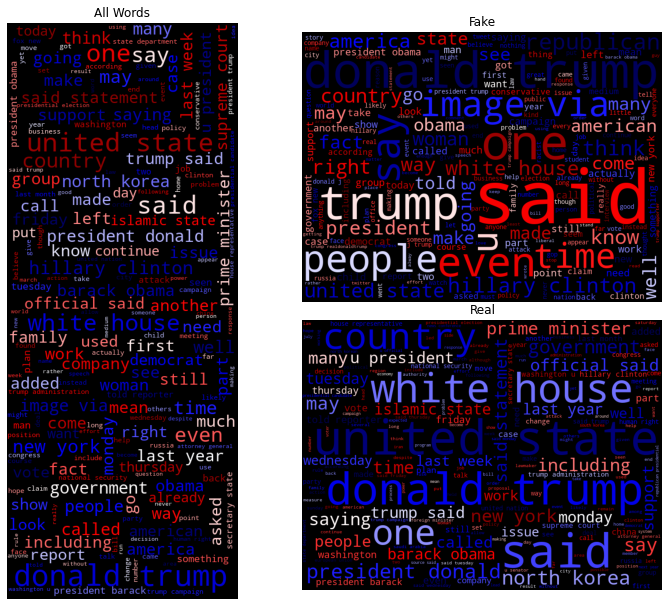

In [71]:
all_cloud = WordCloud(background_color='black', height=1000, width=400, colormap="seismic_r").generate(' '.join(all_words))
fake_cloud = WordCloud(background_color='black', height=600, width=800, colormap="seismic_r").generate(' '.join(fake_words))
real_cloud = WordCloud(background_color='black', height=600, width=800, colormap="seismic_r").generate(' '.join(real_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(fake_cloud)
axs[2].imshow(real_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Fake')
axs[2].set_title('Real')

for ax in axs: ax.axis('off')

## Takeaways
* Said and donald trump are the top two words in the fake news related articles. 
* This could be related to some quates that were infered by the press or misleading. (I'd like to look into this deeper and actualy compare if these statments match what trump acutaly said)

## Bigrams (Fake - Real)

In [74]:
top_20_fake_bigrams = (pd.Series(nltk.ngrams(fake_words, 2))
                      .value_counts()
                      .head(20))

top_20_fake_bigrams.head()

(donald, trump)       11299
(image, via)           6194
(hillary, clinton)     5002
(white, house)         4832
(united, state)        4601
dtype: int64

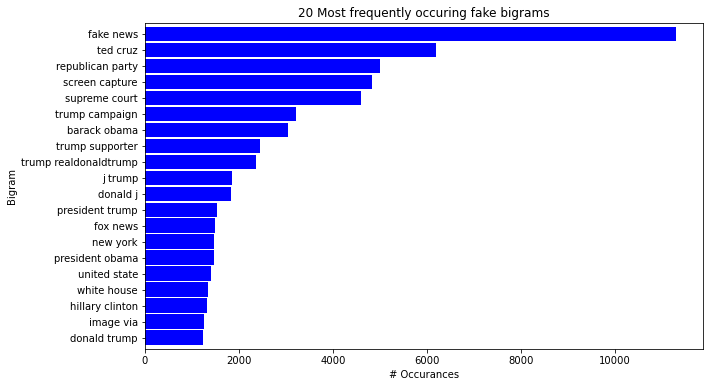

In [76]:
top_20_fake_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring fake bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

ticks, _ = plt.yticks()
labels = top_20_fake_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

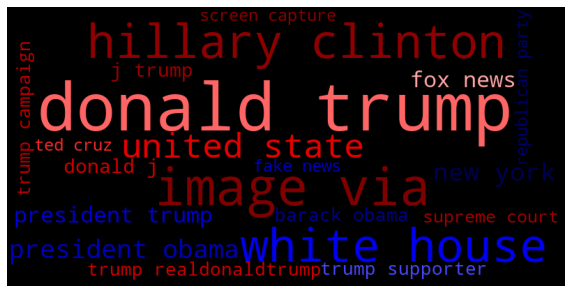

In [93]:
data = {k[0] + ' ' + k[1] : v for k, v in top_20_fake_bigrams.to_dict().items()}
img = WordCloud(random_state=1414, background_color='black', width=800, height=400, colormap="seismic_r").generate_from_frequencies(data)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

# Takeaways 
* The bigrams for fake news articles are filled with "in house" events and places such as supreme count, republican part, and trumps twitter tag. 

In [77]:
top_20_real_bigrams = (pd.Series(nltk.ngrams(real_words, 2))
                      .value_counts()
                      .head(20))

top_20_real_bigrams.head()

(united, state)        12014
(donald, trump)        10051
(white, house)          8304
(president, donald)     5866
(north, korea)          5482
dtype: int64

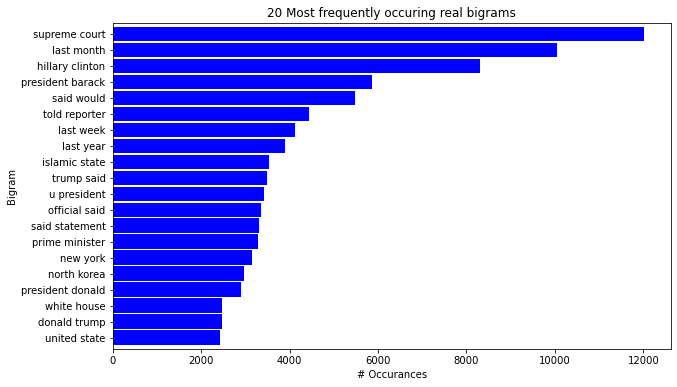

In [78]:
top_20_real_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring real bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_real_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

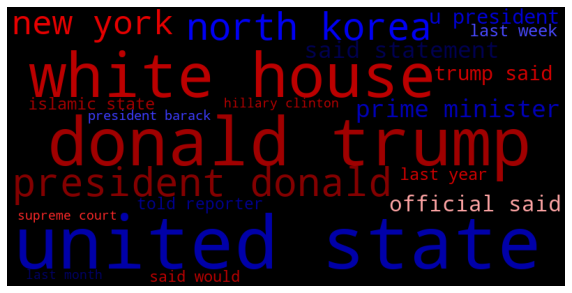

In [92]:
data = {k[0] + ' ' + k[1] : v for k, v in top_20_real_bigrams.to_dict().items()}
img = WordCloud(random_state=1414, background_color='black', width=800, height=400, colormap="seismic_r").generate_from_frequencies(data)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

# Takeaways 
* The bigrams for real news are filled with phrases that represent world events and significant moments in time.

## Trigrams (Real - Fake)

In [79]:
top_20_real_trigrams2 = (pd.Series(nltk.ngrams(real_words, 3))
                      .value_counts()
                      .head(20))

top_20_real_trigrams2.head()

(president, donald, trump)     5796
(u, president, donald)         2493
(president, barack, obama)     1992
(white, house, said)            953
(president, barack, obamas)     900
dtype: int64

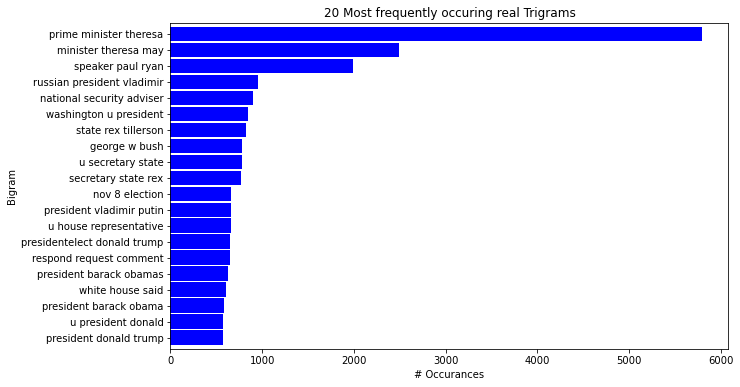

In [80]:
top_20_real_trigrams2.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring real Trigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_real_trigrams2.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

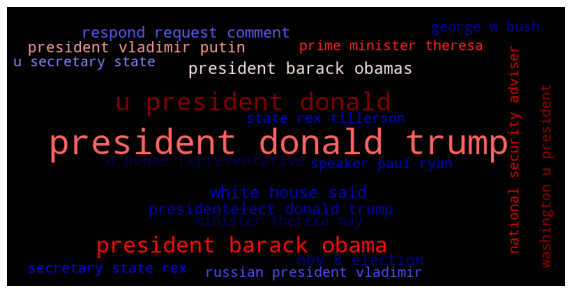

In [94]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_real_trigrams2.to_dict().items()}
img = WordCloud(random_state=1414, background_color='black', colormap="seismic_r", width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [83]:
top_20_fake_trigrams2 = (pd.Series(nltk.ngrams(fake_words, 3))
                      .value_counts()
                      .head(20))

top_20_fake_trigrams2.head()

(donald, j, trump)             1818
(j, trump, realdonaldtrump)    1524
(new, york, time)              1068
(21st, century, wire)           954
(image, via, video)             787
dtype: int64

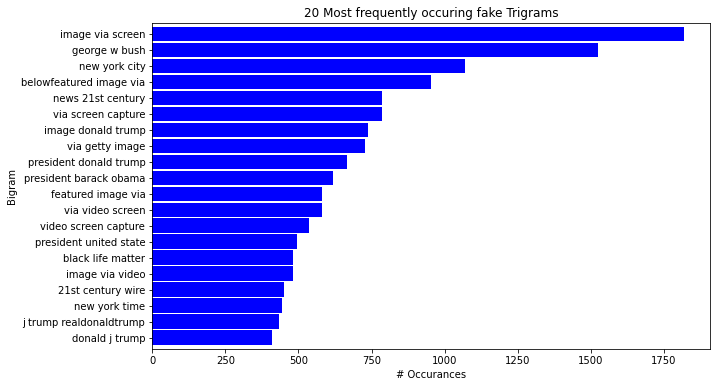

In [85]:
top_20_fake_trigrams2.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring fake Trigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_fake_trigrams2.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

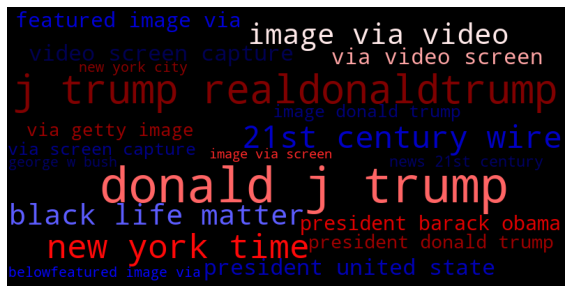

In [95]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_fake_trigrams2.to_dict().items()}
img = WordCloud(random_state=1414, background_color='black', colormap="seismic_r", width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

# Modeling

In [7]:
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(articles_df.clean_text)
y = articles_df.is_fake

In [8]:
X_train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, stratify=y, test_size=.2)

X_train, X_validate, y_train, y_validate = train_test_split(X_train_validate, y_train_validate, stratify=y_train_validate, test_size=.3)

In [9]:
X_train.shape, X_validate.shape, X_test.shape

((21644, 218347), (9276, 218347), (7731, 218347))

In [10]:
y_train.shape, y_validate.shape, y_test.shape

((21644,), (9276,), (7731,))

In [11]:
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

# Establish baseline model

In [12]:
articles_df.is_fake.value_counts()

False    21196
True     17455
Name: is_fake, dtype: int64

In [13]:
train['baseline_predicted'] = False
validate['baseline_predicted'] = False
test['baseline_predicted'] = False

In [14]:
utils.print_model_evaluation(train, 'baseline_predicted')

Accuracy: 54.84%
---
Confusion Matrix
actual              False  True 
baseline_predicted              
False               11869   9775
---
              precision    recall  f1-score   support

       False       0.55      1.00      0.71     11869
        True       0.00      0.00      0.00      9775

    accuracy                           0.55     21644
   macro avg       0.27      0.50      0.35     21644
weighted avg       0.30      0.55      0.39     21644



Baseline accuracy of 55% using True as default prediction for is_fake

# Logistic Regression

In [15]:
lm = LogisticRegression().fit(X_train, y_train)

train['log_predicted'] = lm.predict(X_train)
validate['log_predicted'] = lm.predict(X_validate)

In [16]:
utils.print_model_evaluation(train, 'log_predicted')

Accuracy: 98.62%
---
Confusion Matrix
actual         False  True 
log_predicted              
False          11774    203
True              95   9572
---
              precision    recall  f1-score   support

       False       0.98      0.99      0.99     11869
        True       0.99      0.98      0.98      9775

    accuracy                           0.99     21644
   macro avg       0.99      0.99      0.99     21644
weighted avg       0.99      0.99      0.99     21644



In [17]:
utils.print_model_evaluation(validate, 'log_predicted')

Accuracy: 98.02%
---
Confusion Matrix
actual         False  True 
log_predicted              
False           5020    117
True              67   4072
---
              precision    recall  f1-score   support

       False       0.98      0.99      0.98      5087
        True       0.98      0.97      0.98      4189

    accuracy                           0.98      9276
   macro avg       0.98      0.98      0.98      9276
weighted avg       0.98      0.98      0.98      9276



# Decision Tree

In [18]:
dcn_tree = DecisionTreeClassifier(max_depth=7, random_state=1414)
dcn_tree = dcn_tree.fit(X_train, y_train)

train['dcn_tree_predicted'] = dcn_tree.predict(X_train)
validate['dcn_tree_predicted'] = dcn_tree.predict(X_validate)

In [19]:
utils.print_model_evaluation(train, 'dcn_tree_predicted')

Accuracy: 91.49%
---
Confusion Matrix
actual              False  True 
dcn_tree_predicted              
False               11208   1180
True                  661   8595
---
              precision    recall  f1-score   support

       False       0.90      0.94      0.92     11869
        True       0.93      0.88      0.90      9775

    accuracy                           0.91     21644
   macro avg       0.92      0.91      0.91     21644
weighted avg       0.92      0.91      0.91     21644



In [20]:
utils.print_model_evaluation(validate, 'dcn_tree_predicted')

Accuracy: 90.14%
---
Confusion Matrix
actual              False  True 
dcn_tree_predicted              
False                4744    572
True                  343   3617
---
              precision    recall  f1-score   support

       False       0.89      0.93      0.91      5087
        True       0.91      0.86      0.89      4189

    accuracy                           0.90      9276
   macro avg       0.90      0.90      0.90      9276
weighted avg       0.90      0.90      0.90      9276



# Random Forest

In [21]:
rand_forest = RandomForestClassifier(bootstrap=True, class_weight="balanced", criterion='gini', min_samples_leaf=3, \
                                     n_estimators=100, max_depth=15, random_state=1414)
rand_forest = rand_forest.fit(X_train, y_train)

train['rand_forest_predicted'] = rand_forest.predict(X_train)
validate['rand_forest_predicted'] = rand_forest.predict(X_validate)

In [22]:
utils.print_model_evaluation(train, 'rand_forest_predicted')

Accuracy: 96.09%
---
Confusion Matrix
actual                 False  True 
rand_forest_predicted              
False                  11667    645
True                     202   9130
---
              precision    recall  f1-score   support

       False       0.95      0.98      0.96     11869
        True       0.98      0.93      0.96      9775

    accuracy                           0.96     21644
   macro avg       0.96      0.96      0.96     21644
weighted avg       0.96      0.96      0.96     21644



In [23]:
utils.print_model_evaluation(validate, 'rand_forest_predicted')

Accuracy: 94.91%
---
Confusion Matrix
actual                 False  True 
rand_forest_predicted              
False                   4951    336
True                     136   3853
---
              precision    recall  f1-score   support

       False       0.94      0.97      0.95      5087
        True       0.97      0.92      0.94      4189

    accuracy                           0.95      9276
   macro avg       0.95      0.95      0.95      9276
weighted avg       0.95      0.95      0.95      9276



# K Nearest Neighbors

In [24]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn = knn.fit(X_train, y_train)

train['knn_predicted'] = knn.predict(X_train)
validate['knn_predicted'] = knn.predict(X_validate)

In [25]:
utils.print_model_evaluation(train, 'knn_predicted')

Accuracy: 88.66%
---
Confusion Matrix
actual         False  True 
knn_predicted              
False          11551   2136
True             318   7639
---
              precision    recall  f1-score   support

       False       0.84      0.97      0.90     11869
        True       0.96      0.78      0.86      9775

    accuracy                           0.89     21644
   macro avg       0.90      0.88      0.88     21644
weighted avg       0.90      0.89      0.88     21644



In [26]:
utils.print_model_evaluation(validate, 'knn_predicted')

Accuracy: 84.22%
---
Confusion Matrix
actual         False  True 
knn_predicted              
False           4881   1258
True             206   2931
---
              precision    recall  f1-score   support

       False       0.80      0.96      0.87      5087
        True       0.93      0.70      0.80      4189

    accuracy                           0.84      9276
   macro avg       0.86      0.83      0.83      9276
weighted avg       0.86      0.84      0.84      9276



# MVP

In [27]:
test['log_predicted'] = lm.predict(X_test)

In [28]:
utils.print_model_evaluation(test, 'log_predicted')

Accuracy: 97.68%
---
Confusion Matrix
actual         False  True 
log_predicted              
False           4180    119
True              60   3372
---
              precision    recall  f1-score   support

       False       0.97      0.99      0.98      4240
        True       0.98      0.97      0.97      3491

    accuracy                           0.98      7731
   macro avg       0.98      0.98      0.98      7731
weighted avg       0.98      0.98      0.98      7731

